In [1]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import matplotlib.image as mpimg 
# !pip install scikit-build
# !pip install imgaug
# from imgaug import augmenters as iaa
import pandas as pd 
import glob 

In [2]:
# !git clone https://www.github.com/matterport/Mask_RCNN.git


In [3]:
os.chdir('Mask_RCNN')

In [4]:
# !pip install -r requirements.txt

In [5]:
!python setup.py -q install

Traceback (most recent call last):
  File "setup.py", line 7, in <module>
    import pip
ImportError: No module named pip


In [6]:
# Import Mask RCNN
#!pip install -r requirements.txt
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


array([[[0.02352941, 0.02352941, 0.02352941],
        [0.03921569, 0.03921569, 0.03921569],
        [0.03921569, 0.03921569, 0.03921569],
        ...,
        [0.18431373, 0.18431373, 0.18431373],
        [0.2       , 0.2       , 0.2       ],
        [0.1254902 , 0.1254902 , 0.1254902 ]],

       [[0.05098039, 0.05098039, 0.05098039],
        [0.08627451, 0.08627451, 0.08627451],
        [0.08627451, 0.08627451, 0.08627451],
        ...,
        [0.38431373, 0.38431373, 0.38431373],
        [0.42745098, 0.42745098, 0.42745098],
        [0.25882354, 0.25882354, 0.25882354]],

       [[0.04705882, 0.04705882, 0.04705882],
        [0.08627451, 0.08627451, 0.08627451],
        [0.08627451, 0.08627451, 0.08627451],
        ...,
        [0.37254903, 0.37254903, 0.37254903],
        [0.41568628, 0.41568628, 0.41568628],
        [0.24705882, 0.24705882, 0.24705882]],

       ...,

       [[0.3529412 , 0.3529412 , 0.3529412 ],
        [0.62352943, 0.62352943, 0.62352943],
        [0.59607846, 0

In [75]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
   
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = mpimg.imread('../sample/'+fp) 
        return ds

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        if len(annotations) != 4:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
            x = annotations[0]
            y = annotations[1]
            w = annotations[2]
            h = annotations[3]
            mask_instance = mask.copy()
            cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
            mask = mask_instance
            class_ids[0] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [8]:
ORIG_SIZE = 1024

In [9]:
anns = pd.DataFrame(columns=['image','x','y','width','height'])
anns

,image,x,y,width,height


In [10]:
with open('../sample.json') as f:
    data = json.load(f)
anndict = {}
for key in data:
    img = data[key]
    imgdict = img['regions'][0]['shape_attributes']
    anns = anns.append({'image':img['filename'], 'x':imgdict['x'], 'y':imgdict['y'], 'width':imgdict['width'], 'height':imgdict['height']},ignore_index=True)
    anndict[img['filename']]=[imgdict['x'],imgdict['y'],imgdict['width'],imgdict['height']]
anns

,image,x,y,width,height
0,00006693_000.png,113,99,852,874
1,00006683_000.png,144,109,726,641
2,00006687_002.png,148,130,746,718
3,00006683_006.png,200,127,718,572
4,00006691_001.png,139,87,774,868
5,00006683_003.png,144,49,746,730
6,00006689_001.png,103,76,767,539
7,00006686_000.png,125,118,781,734


In [11]:
files = os.listdir('../sample/')
imageList = []
for file in files:
        if file.endswith('.png'):
            imageList.append(file)

In [12]:
image_fps = imageList
image_annotations = anndict

In [83]:
# prepare the training dataset
dataset_train = DetectorDataset(image_fps, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()
len(dataset_train.load_mask(0)[0])

1024

In [14]:
random.choice(imageList)

'00006687_002.png'

(1024, 1024)
144 890 49 779


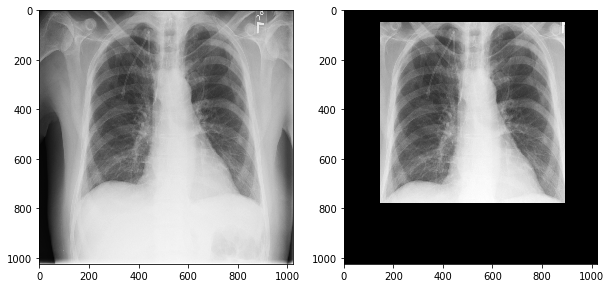

In [15]:
# Load and display random samples and their bounding boxes
# Suggestion: Run this a few times to see different examples. 

image_fp = random.choice(imageList)
image = mpimg.imread('../sample/'+image_fp) 

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
bb = image_annotations[image_fp]
print(bb[0],bb[0]+bb[2],bb[1],bb[1]+bb[3])
for i in range(bb[0],bb[0]+bb[2]):
    for j in range(bb[1],bb[1]+bb[3]):
        masked [j,i] = image[j,i]
plt.imshow(masked, cmap='gray')


In [84]:
class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8 
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
#     IMAGE_MIN_DIM = 256
#     IMAGE_MAX_DIM = 256
#     #RPN_ANCHOR_SCALES = (32, 64, 128, 256)
#     TRAIN_ROIS_PER_IMAGE = 32
#     MAX_GT_INSTANCES = 3
#     DETECTION_MAX_INSTANCES = 3
#     DETECTION_MIN_CONFIDENCE = 0.9
#     DETECTION_NMS_THRESHOLD = 0.1

    STEPS_PER_EPOCH = 100
config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'rpn_class_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

In [85]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir='./')

In [86]:
dataset_val = DetectorDataset(image_fps, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

In [80]:
# # Image augmentation 
# augmentation = iaa.SomeOf((0, 1), [
#     iaa.Fliplr(0.5),
#     iaa.Affine(
#         scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
#         translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
#         rotate=(-25, 25),
#         shear=(-8, 8)
#     ),
#     iaa.Multiply((0.9, 1.1))
# ])

In [87]:
NUM_EPOCHS = 1

# Train Mask-RCNN Model 
import warnings 
warnings.filterwarnings("ignore")
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=NUM_EPOCHS, 
            layers='all')
#


Starting at epoch 0. LR=0.001

Checkpoint Path: ./pneumonia20201031T1643/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (Batch

ERROR:root:Error processing image {'orig_height': 1024, 'annotations': [113, 99, 852, 874], 'path': '00006693_000.png', 'source': 'pneumonia', 'orig_width': 1024, 'id': 7}
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/numpy/lib/arraypad.py", line 1036, in _normalize_shape
    shape_arr = np.broadcast_to(shape_arr, (ndims, 2))
  File "/usr/local/lib/python3.5/dist-packages/numpy/lib/stride_tricks.py", line 173, in broadcast_to
    return _broadcast_to(array, shape, subok=subok, readonly=True)
  File "/usr/local/lib/python3.5/dist-packages/numpy/lib/stride_tricks.py", line 128, in _broadcast_to
    op_flags=[op_flag], itershape=shape, order='C').itviews[0]
ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (3,2) and requested shape (2,2)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/host/Mask_RCNN/mrcnn/model.py", line 1709, in data_generato

ValueError: Unable to create correctly shaped tuple from [(0, 0), (0, 0), (0, 0)]ERROR:root:Error processing image {'orig_height': 1024, 'annotations': [148, 130, 746, 718], 'path': '00006687_002.png', 'source': 'pneumonia', 'orig_width': 1024, 'id': 4}
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/numpy/lib/arraypad.py", line 1036, in _normalize_shape
    shape_arr = np.broadcast_to(shape_arr, (ndims, 2))
  File "/usr/local/lib/python3.5/dist-packages/numpy/lib/stride_tricks.py", line 173, in broadcast_to
    return _broadcast_to(array, shape, subok=subok, readonly=True)
  File "/usr/local/lib/python3.5/dist-packages/numpy/lib/stride_tricks.py", line 128, in _broadcast_to
    op_flags=[op_flag], itershape=shape, order='C').itviews[0]
ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (3,2) and requested shape (2,2)

During handling of the above exception, another exception occurred:

Traceback (most recen

ValueError: Unable to create correctly shaped tuple from [(0, 0), (0, 0), (0, 0)]ERROR:root:Error processing image {'orig_height': 1024, 'annotations': [139, 87, 774, 868], 'path': '00006691_001.png', 'source': 'pneumonia', 'orig_width': 1024, 'id': 6}
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/numpy/lib/arraypad.py", line 1036, in _normalize_shape
    shape_arr = np.broadcast_to(shape_arr, (ndims, 2))
  File "/usr/local/lib/python3.5/dist-packages/numpy/lib/stride_tricks.py", line 173, in broadcast_to
    return _broadcast_to(array, shape, subok=subok, readonly=True)
  File "/usr/local/lib/python3.5/dist-packages/numpy/lib/stride_tricks.py", line 128, in _broadcast_to
    op_flags=[op_flag], itershape=shape, order='C').itviews[0]
ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (3,2) and requested shape (2,2)

During handling of the above exception, another exception occurred:

Traceback (most recent

ValueError: Unable to create correctly shaped tuple from [(0, 0), (0, 0), (0, 0)]
ERROR:root:Error processing image {'orig_height': 1024, 'annotations': [125, 118, 781, 734], 'path': '00006686_000.png', 'source': 'pneumonia', 'orig_width': 1024, 'id': 3}
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/numpy/lib/arraypad.py", line 1036, in _normalize_shape
    shape_arr = np.broadcast_to(shape_arr, (ndims, 2))
  File "/usr/local/lib/python3.5/dist-packages/numpy/lib/stride_tricks.py", line 173, in broadcast_to
    return _broadcast_to(array, shape, subok=subok, readonly=True)
  File "/usr/local/lib/python3.5/dist-packages/numpy/lib/stride_tricks.py", line 128, in _broadcast_to
    op_flags=[op_flag], itershape=shape, order='C').itviews[0]
ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (3,2) and requested shape (2,2)

During handling of the above exception, another exception occurred:

Traceback (most rece

ValueError: Unable to create correctly shaped tuple from [(0, 0), (0, 0), (0, 0)]Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/numpy/lib/stride_tricks.py", line 128, in _broadcast_to
    op_flags=[op_flag], itershape=shape, order='C').itviews[0]
  File "/host/Mask_RCNN/mrcnn/model.py", line 1219, in load_image_gt
    mode=config.IMAGE_RESIZE_MODE)
ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (3,2) and requested shape (2,2)
  File "/usr/local/lib/python3.5/dist-packages/numpy/lib/arraypad.py", line 1036, in _normalize_shape
    shape_arr = np.broadcast_to(shape_arr, (ndims, 2))
  File "/host/Mask_RCNN/mrcnn/utils.py", line 459, in resize_image
    image = np.pad(image, padding, mode='constant', constant_values=0)
  File "/usr/local/lib/python3.5/dist-packages/numpy/lib/arraypad.py", line 1301, in pad
    pad_width = _validate_lengths(narray, pad_width)


During handling of the above exception, another

ValueError: Unable to create correctly shaped tuple from [(0, 0), (0, 0), (0, 0)]  File "/host/Mask_RCNN/mrcnn/model.py", line 1219, in load_image_gt
    mode=config.IMAGE_RESIZE_MODE)
  File "/usr/local/lib/python3.5/dist-packages/numpy/lib/arraypad.py", line 1039, in _normalize_shape
    raise ValueError(fmt % (shape,))


  File "/host/Mask_RCNN/mrcnn/utils.py", line 459, in resize_image
    image = np.pad(image, padding, mode='constant', constant_values=0)
ValueError: Unable to create correctly shaped tuple from [(0, 0), (0, 0), (0, 0)]
  File "/usr/local/lib/python3.5/dist-packages/numpy/lib/arraypad.py", line 1301, in pad
    pad_width = _validate_lengths(narray, pad_width)
  File "/usr/local/lib/python3.5/dist-packages/numpy/lib/arraypad.py", line 1080, in _validate_lengths
    normshp = _normalize_shape(narray, number_elements)
  File "/usr/local/lib/python3.5/dist-packages/numpy/lib/arraypad.py", line 1039, in _normalize_shape
    raise ValueError(fmt % (shape,))
ValueError: Un

ValueError: Unable to create correctly shaped tuple from [(0, 0), (0, 0), (0, 0)]ERROR:root:Error processing image {'orig_height': 1024, 'annotations': [139, 87, 774, 868], 'path': '00006691_001.png', 'source': 'pneumonia', 'orig_width': 1024, 'id': 6}
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/numpy/lib/arraypad.py", line 1036, in _normalize_shape
    shape_arr = np.broadcast_to(shape_arr, (ndims, 2))
  File "/usr/local/lib/python3.5/dist-packages/numpy/lib/stride_tricks.py", line 173, in broadcast_to
    return _broadcast_to(array, shape, subok=subok, readonly=True)
  File "/usr/local/lib/python3.5/dist-packages/numpy/lib/stride_tricks.py", line 128, in _broadcast_to
    op_flags=[op_flag], itershape=shape, order='C').itviews[0]
ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (3,2) and requested shape (2,2)

During handling of the above exception, another exception occurred:

Traceback (most recent

ValueError: Unable to create correctly shaped tuple from [(0, 0), (0, 0), (0, 0)]


Traceback (most recent call last):
ERROR:root:Error processing image {'orig_height': 1024, 'annotations': [103, 76, 767, 539], 'path': '00006689_001.png', 'source': 'pneumonia', 'orig_width': 1024, 'id': 5}
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/numpy/lib/arraypad.py", line 1036, in _normalize_shape
    shape_arr = np.broadcast_to(shape_arr, (ndims, 2))
  File "/usr/local/lib/python3.5/dist-packages/numpy/lib/stride_tricks.py", line 173, in broadcast_to
    return _broadcast_to(array, shape, subok=subok, readonly=True)
  File "/usr/local/lib/python3.5/dist-packages/numpy/lib/stride_tricks.py", line 128, in _broadcast_to
    op_flags=[op_flag], itershape=shape, order='C').itviews[0]
ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (3,2) and requested shape (2,2)

During handling of the above exception, another excep

Epoch 1/1


ValueError: Unable to create correctly shaped tuple from [(0, 0), (0, 0), (0, 0)]

In [ ]:
# select trained model 
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else: 
      
      checkpoint = os.path.join(dir_name, checkpoints[-1])
      fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))